#  ball classification

## Preparing data

In [ ]:
# from
!wget -nv -O '30 Types of Balls.zip' 'https://emailpsuac-my.sharepoint.com/:u:/g/personal/6410210079_email_psu_ac_th/ERnxebYBhMhLvoj3Z5Md8yIBkT0hf09YgjhDeFKiNg4Kvw?download=1'
!rm -rf balls/
!unzip -q '30 Types of Balls.zip' -d 'balls'

2024-03-12 14:05:04 URL:https://emailpsuac-my.sharepoint.com/personal/6410210079_email_psu_ac_th/Documents/dataset/30%20Types%20of%20Balls.zip?ga=1 [151134833/151134833] -> "30 Types of Balls.zip" [1]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir = "balls/train"

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

## Train Test Split

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3595 files belonging to 30 classes.
Using 2876 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3595 files belonging to 30 classes.
Using 719 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['baseball', 'basketball', 'beachballs', 'billiard ball', 'bowling ball', 'brass', 'buckeyballs', 'cannon ball', 'chrochet ball', 'cricket ball', 'crystal ball', 'eyeballs', 'football', 'golf ball', 'marble', 'meat ball', 'medicine ball', 'paint balls', 'pokeman balls', 'puffballs', 'rubberband ball', 'screwballs', 'sepak takraw ball', 'soccer ball', 'tennis ball', 'tether ball', 'volley ball', 'water polo ball', 'wiffle ball', 'wrecking ball']


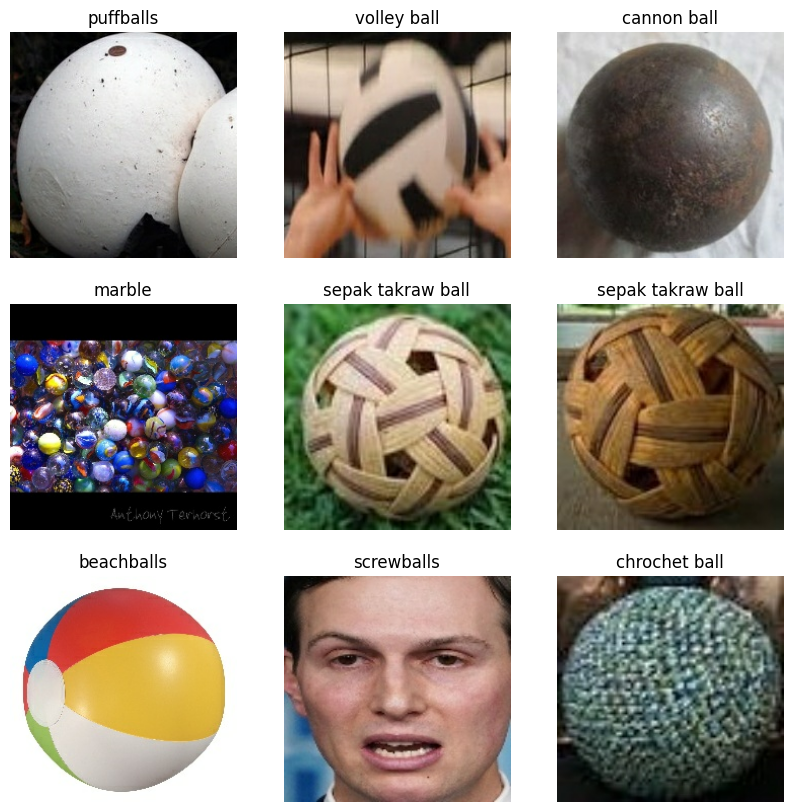

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Train model

In [ ]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
90/90 [==============================] - 173s 2s/step - loss: 3.2048 - accuracy: 0.1328 - val_loss: 2.6988 - val_accuracy: 0.2601
Epoch 2/15
90/90 [==============================] - 159s 2s/step - loss: 2.2959 - accuracy: 0.3759 - val_loss: 2.1250 - val_accuracy: 0.4186
Epoch 3/15
90/90 [==============================] - 158s 2s/step - loss: 1.8530 - accuracy: 0.4802 - val_loss: 1.8457 - val_accuracy: 0.5160
Epoch 4/15
90/90 [==============================] - 165s 2s/step - loss: 1.5730 - accuracy: 0.5497 - val_loss: 1.6687 - val_accuracy: 0.5369
Epoch 5/15
90/90 [==============================] - 159s 2s/step - loss: 1.3661 - accuracy: 0.6067 - val_loss: 1.5736 - val_accuracy: 0.5661
Epoch 6/15
90/90 [==============================] - 160s 2s/step - loss: 1.2198 - accuracy: 0.6474 - val_loss: 1.3564 - val_accuracy: 0.6203
Epoch 7/15
90/90 [==============================] - 159s 2s/step - loss: 1.0693 - accuracy: 0.6791 - val_loss: 1.5171 - val_accuracy: 0.5981
Epoch 8/15
90

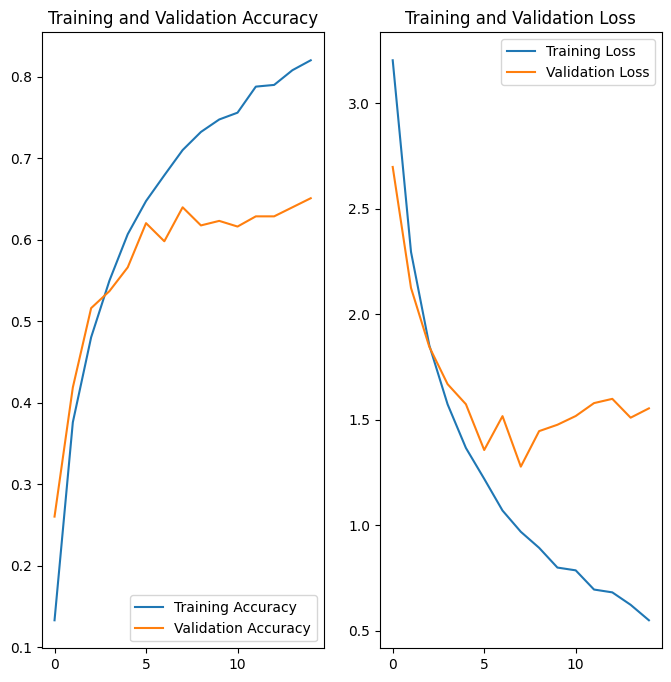

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate

In [ ]:
score = model.evaluate(val_ds)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

23/23 [==============================] - 10s 438ms/step - loss: 1.5540 - accuracy: 0.6509
Test loss: 1.5539510250091553
Test accuracy: 0.6509040594100952


In [ ]:
y_pred = np.argmax(model.predict(val_ds), axis=-1)
test_label = np.concatenate([y for x, y in val_ds], axis=0)
con_mat = tf.math.confusion_matrix(labels=test_label, predictions=y_pred).numpy()
con_mat

23/23 [==============================] - 0s 19ms/step


array([[ 8,  6,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  3,  1,  1,  1,
         0,  0,  0,  1,  0,  0,  0,  1,  2,  1,  0,  0,  0,  0],
       [ 0, 12,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  2,
         0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  7,  1, 19,  3,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0, 16,  0,  0,  1,  0,  1,  1,  0,  1,  0,  0,  0,
         1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1],
       [ 1,  0,  0,  1,  0,  9,  0,  2,  0,  0,  0,  0,  0,  0,  1,  0,
         1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2],
       [ 0,  2,  0,  0,  0,  0, 10,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0, 33,  

In [ ]:
import pandas as pd
import seaborn as sns

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_names,
                     columns = class_names)

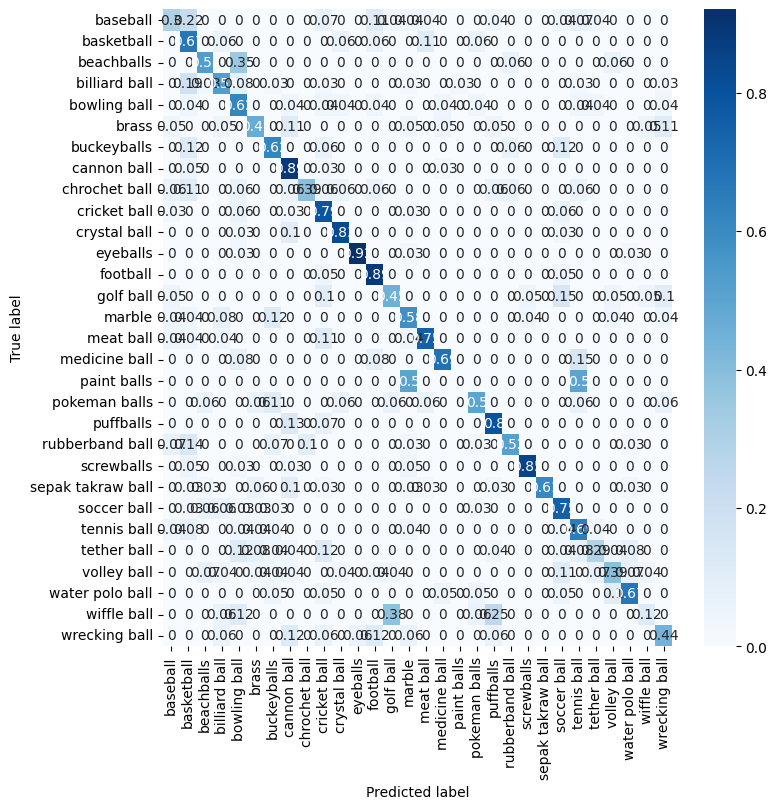

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Save & Load model

In [ ]:
import pickle

model_filename = "cnn_model.pickle"

# save model
pickle.dump(model, open(model_filename , "wb"))

# load model
loaded_model = pickle.load(open(model_filename , "rb"))

#predict
y_pred = loaded_model.predict(val_ds)
y_pred

23/23 [==============================] - 0s 14ms/step


array([[ -3.244237 ,   6.8259516,  -5.2939653, ...,   3.9217272,
         -7.3683767,   1.1725163],
       [  5.5262833,   5.0540543,  -9.542262 , ...,   3.274983 ,
         -8.933729 ,   1.1320305],
       [  5.262643 ,   2.6224828,  -7.5791707, ..., -15.10763  ,
         -4.209735 ,   4.3307257],
       ...,
       [  6.256473 ,   3.3344269, -12.908882 , ..., -10.050119 ,
          3.0927243,   1.6239916],
       [ -7.2590847,  -4.931811 ,  -5.233422 , ...,  -1.8392531,
         -8.105036 ,  -3.285683 ],
       [ -0.2568481,  -4.610448 ,  -4.555256 , ...,   5.961008 ,
         -9.994163 ,  -2.139224 ]], dtype=float32)

## Test (Predict)

In [ ]:
import random

test_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftaishansports.com.sg%2Fwp-content%2Fuploads%2F2019%2F09%2FSepak-Takraw-Ball.jpg&f=1&nofb=1&ipt=714e7e42fc22123e981a97b11a85d61e0f9872f17dc3394b56a26ed676dc984a&ipo=images"
test_path = tf.keras.utils.get_file(str(random.random()), origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to sepak takraw ball with a 87.07 percent confidence.
